# History Summary

In [3]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

### Get all History File Paths

In [5]:
output_dir = './summary/'
history_dir = './history/'

versions, datasets, fx_models, clf_models, runs, paths = [], [], [], [], [], []

for version in os.listdir(history_dir):
    version_dir = os.path.join(history_dir,version)
    for dataset in os.listdir(version_dir):
        dataset_dir = os.path.join(version_dir,dataset)
        for model in os.listdir(dataset_dir):
            fx_model = '_'.join(model.split('_')[:-1])
            clf_model = model.split('_')[-1]
            model_dir = os.path.join(dataset_dir,model)
            for run in os.listdir(model_dir):
                path = os.path.join(model_dir,run,'history.pt')
                if not os.path.isfile(path): continue
                versions.append(version)
                datasets.append(dataset)
                fx_models.append(fx_model)
                clf_models.append(clf_model)
                runs.append(run)
                paths.append(path)

history_files = pd.DataFrame.from_dict(dict(version=versions,dataset=datasets,fx_model=fx_models,clf_model=clf_models,run=runs,path=paths))
history_files.describe()

,version,dataset,fx_model,clf_model,run,path
count,420,420,420,420,420,420
unique,2,7,6,2,5,420
top,v1.2,RAVDESS,WAV2VEC2_BASE,DENSE,Run1,./history/v1.2/RAVDESS/WAV2VEC2_BASE_DENSE/Run...
freq,210,60,70,210,84,1


### Get by Classifier

In [6]:
dense_history_files = history_files[history_files.clf_model=='DENSE']
probing_history_files = history_files[history_files.clf_model=='PROBING']

##### DENSE

In [7]:
mean_accs, std_accs, max_accs, models, datasets = [], [], [], [], []
for model in dense_history_files.fx_model.unique():
    for dataset in dense_history_files.dataset.unique():
        run_df = dense_history_files[(dense_history_files.dataset==dataset) & (dense_history_files.fx_model==model)]
        test_accs = []
        for run in range(run_df.shape[0]):
            history = torch.load(run_df.iloc[run].path)
            test_accs.append(history['test_acc'][history['val_acc'].index(max(history['val_acc']))])
        mean_accs.append(np.mean(test_accs))
        std_accs.append(np.std(test_accs))
        max_accs.append(np.max(test_accs))
        models.append(model)
        datasets.append(dataset)

dense_summary = pd.DataFrame.from_dict(dict(dataset=datasets,model=models,max_acuracy=max_accs,mean_accuracy=mean_accs,std_accuracy=std_accs))
dense_summary.sort_values(['dataset','model']).reset_index(drop=True).to_csv(os.path.join(output_dir,'dense_summary.csv'))

##### PROBING

In [8]:
mean_accs, std_accs, models, datasets = [], [], [], []
for model in probing_history_files.fx_model.unique():
    for dataset in probing_history_files.dataset.unique():
        run_df = probing_history_files[(probing_history_files.dataset==dataset) & (probing_history_files.fx_model==model)]
        test_accs = []
        for run in range(run_df.shape[0]):
            history = torch.load(run_df.iloc[run].path)
            hs_idx = np.argmax(history['val_acc'],axis=0)
            ts_acc = np.array(history['test_acc']).transpose()
            test_accs.append([acc[idx] for acc, idx in zip (ts_acc,hs_idx)])

        mean_accs.append(np.mean(test_accs,axis=0))
        std_accs.append(np.std(test_accs,axis=0))
        models.append(model)
        datasets.append(dataset)

probing_summary = pd.DataFrame.from_dict(dict(dataset=datasets,model=models,mean_accuracy=mean_accs,std_accuracy=std_accs))
probing_summary.sort_values(['dataset','model']).reset_index(drop=True).to_csv(os.path.join(output_dir,'probing_summary.csv'))

---

### Plots

#### Dataset wise

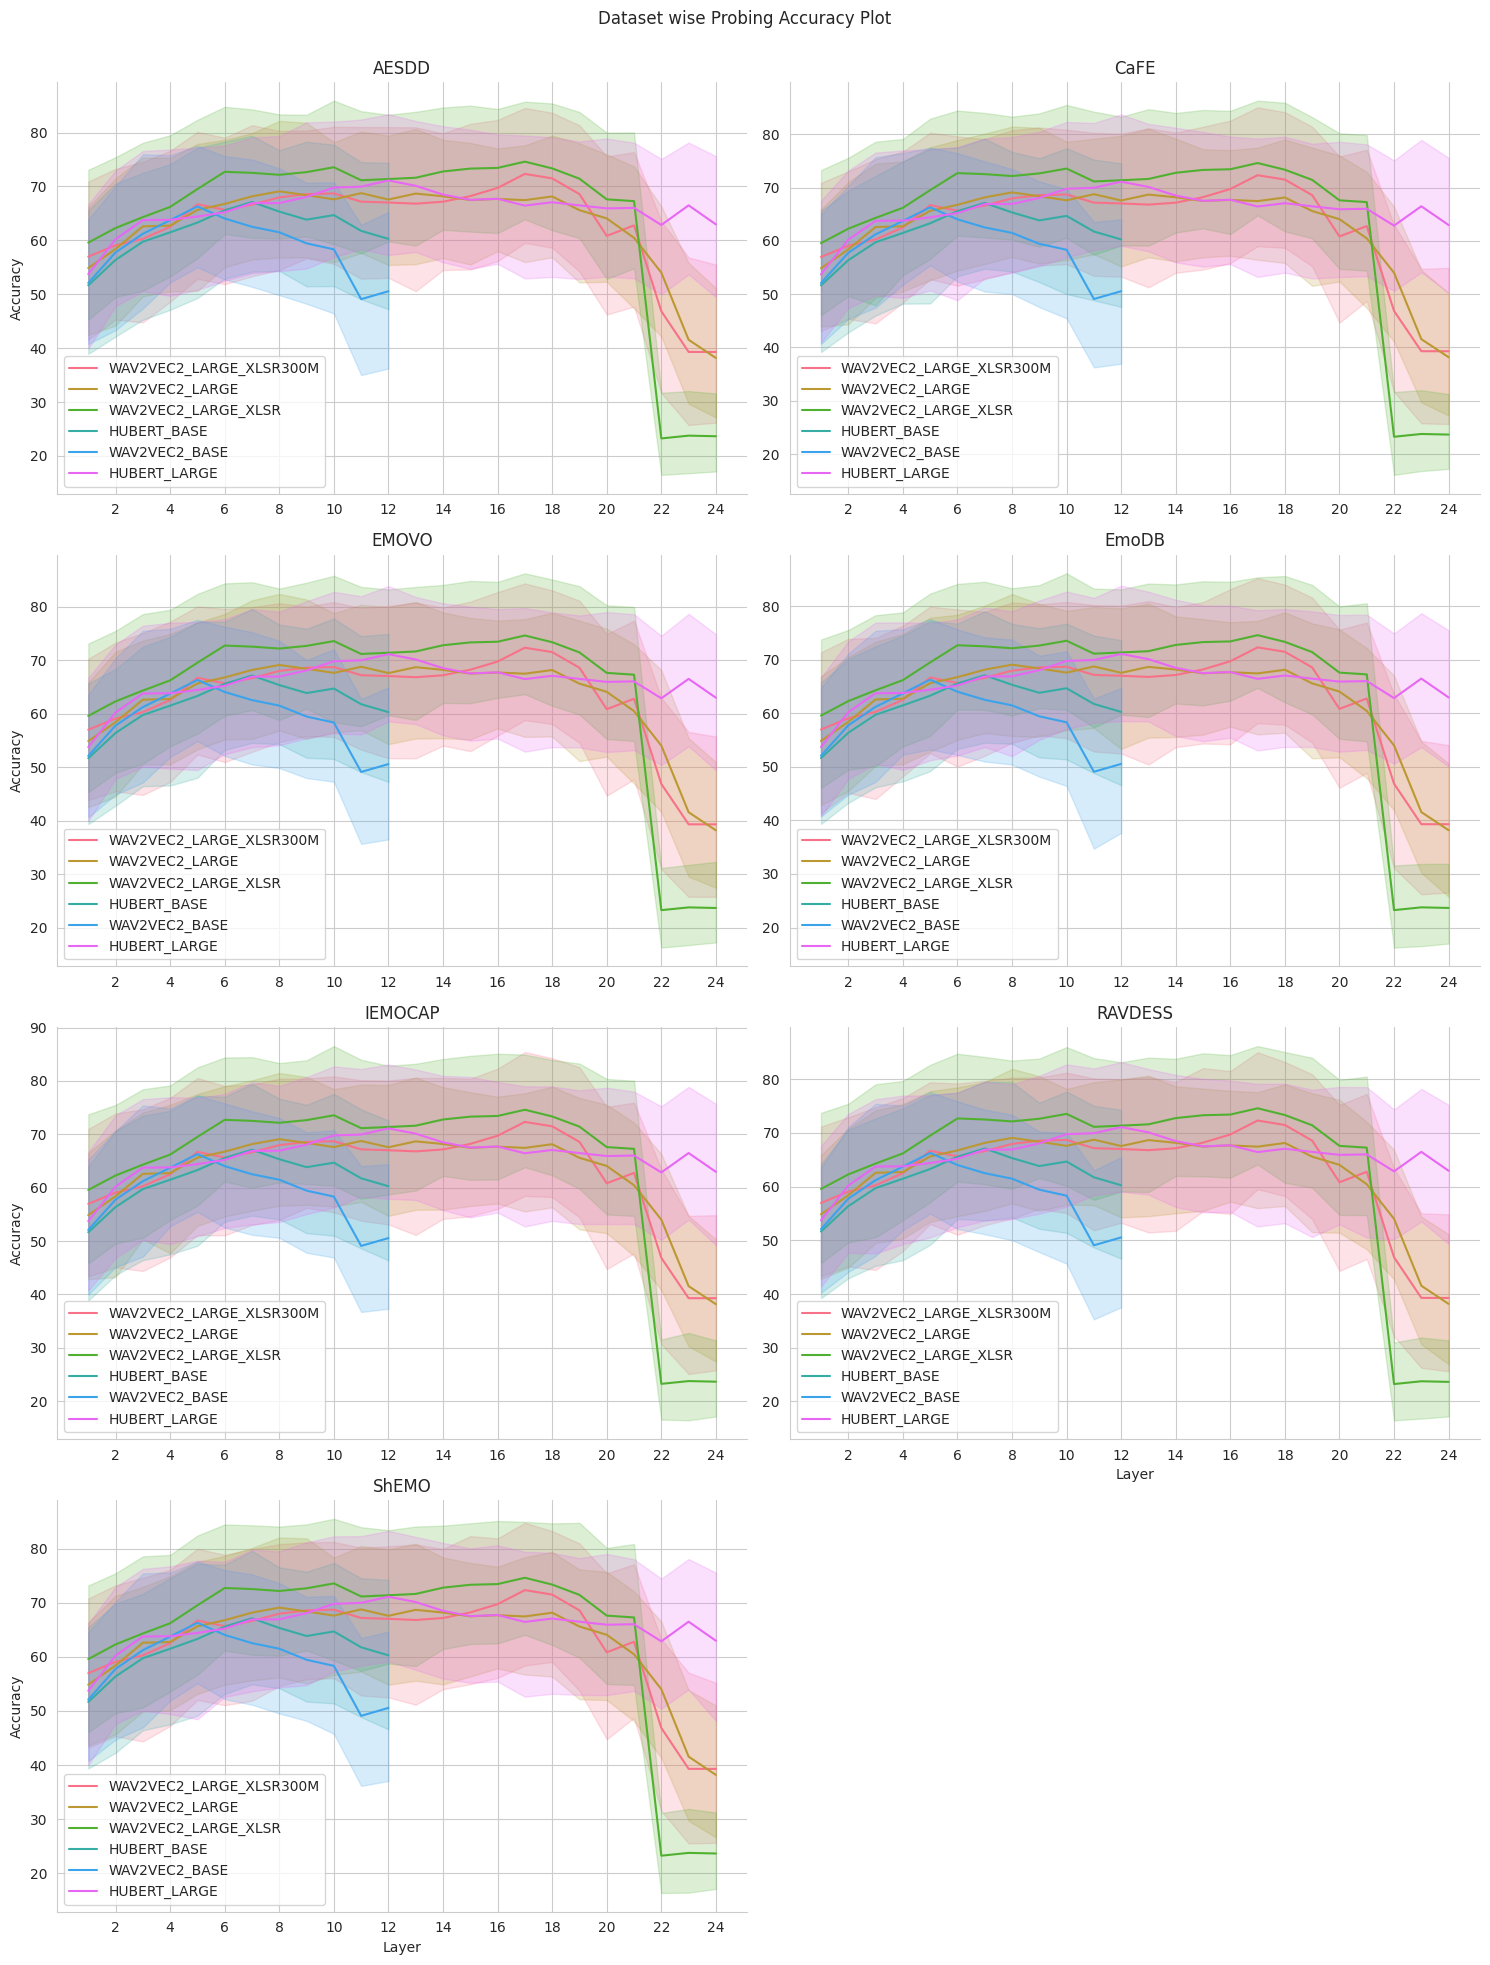

In [11]:
# Set figure
fig, ax = plt.subplots(4, 2,figsize=(15,20))
sns.set_style('whitegrid')

axes = np.array(ax).flatten()
datasets = sorted(probing_summary.dataset.unique())
for idx in range(len(datasets)):
    ax = axes[idx]
    dataset= datasets[idx]
    mean_accs, layers, models = [], [], []
    df = probing_summary[probing_summary.dataset==dataset]
    for row in range(probing_summary.shape[0]):
        mean_accs.extend(probing_summary.iloc[row].mean_accuracy)
        models.extend(([probing_summary.iloc[row].model]*len(probing_summary.iloc[row].mean_accuracy)))
        layers.extend([*range(1,len(probing_summary.iloc[row].mean_accuracy)+1)])
    df = pd.DataFrame.from_dict(dict(model=models,layer=layers,mean_accuracy=mean_accs))

    # Plot the lines
    sns.lineplot(df ,x='layer',y='mean_accuracy', hue='model',dashes=False,palette=sns.color_palette("husl",len(df.model.unique())),ax=ax)   
    # Adjust border
    sns.despine(top=True,right=True)

    # Set Labels, legends and ticks
    ax.set_title(dataset)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend(facecolor="w")#,loc=4,title='IDR')
    ax.set_xticks([*range(2,25,2)],labels=[*range(2,25,2)])
    # ax.set_xlim(1,30.6)

# Plot
axes[-2].set_xlabel("Layer")
axes[-3].set_xlabel("Layer")
axes[0].set_ylabel("Accuracy")
axes[2].set_ylabel("Accuracy")
axes[4].set_ylabel("Accuracy")
axes[6].set_ylabel("Accuracy")
axes[-1].axis('off')
plt.suptitle('Dataset wise Probing Accuracy Plot\n\n')
plt.tight_layout()

plt.savefig(os.path.join(output_dir,'dataset_wise_probing_accuracy_plot.png'),bbox_inches="tight");
# plt.savefig(os.path.join(output_dir,'dataset_wise_probing_accuracy_plot.svg'),bbox_inches="tight");

# plt.clf();
# plt.close('all');

#### Model wise

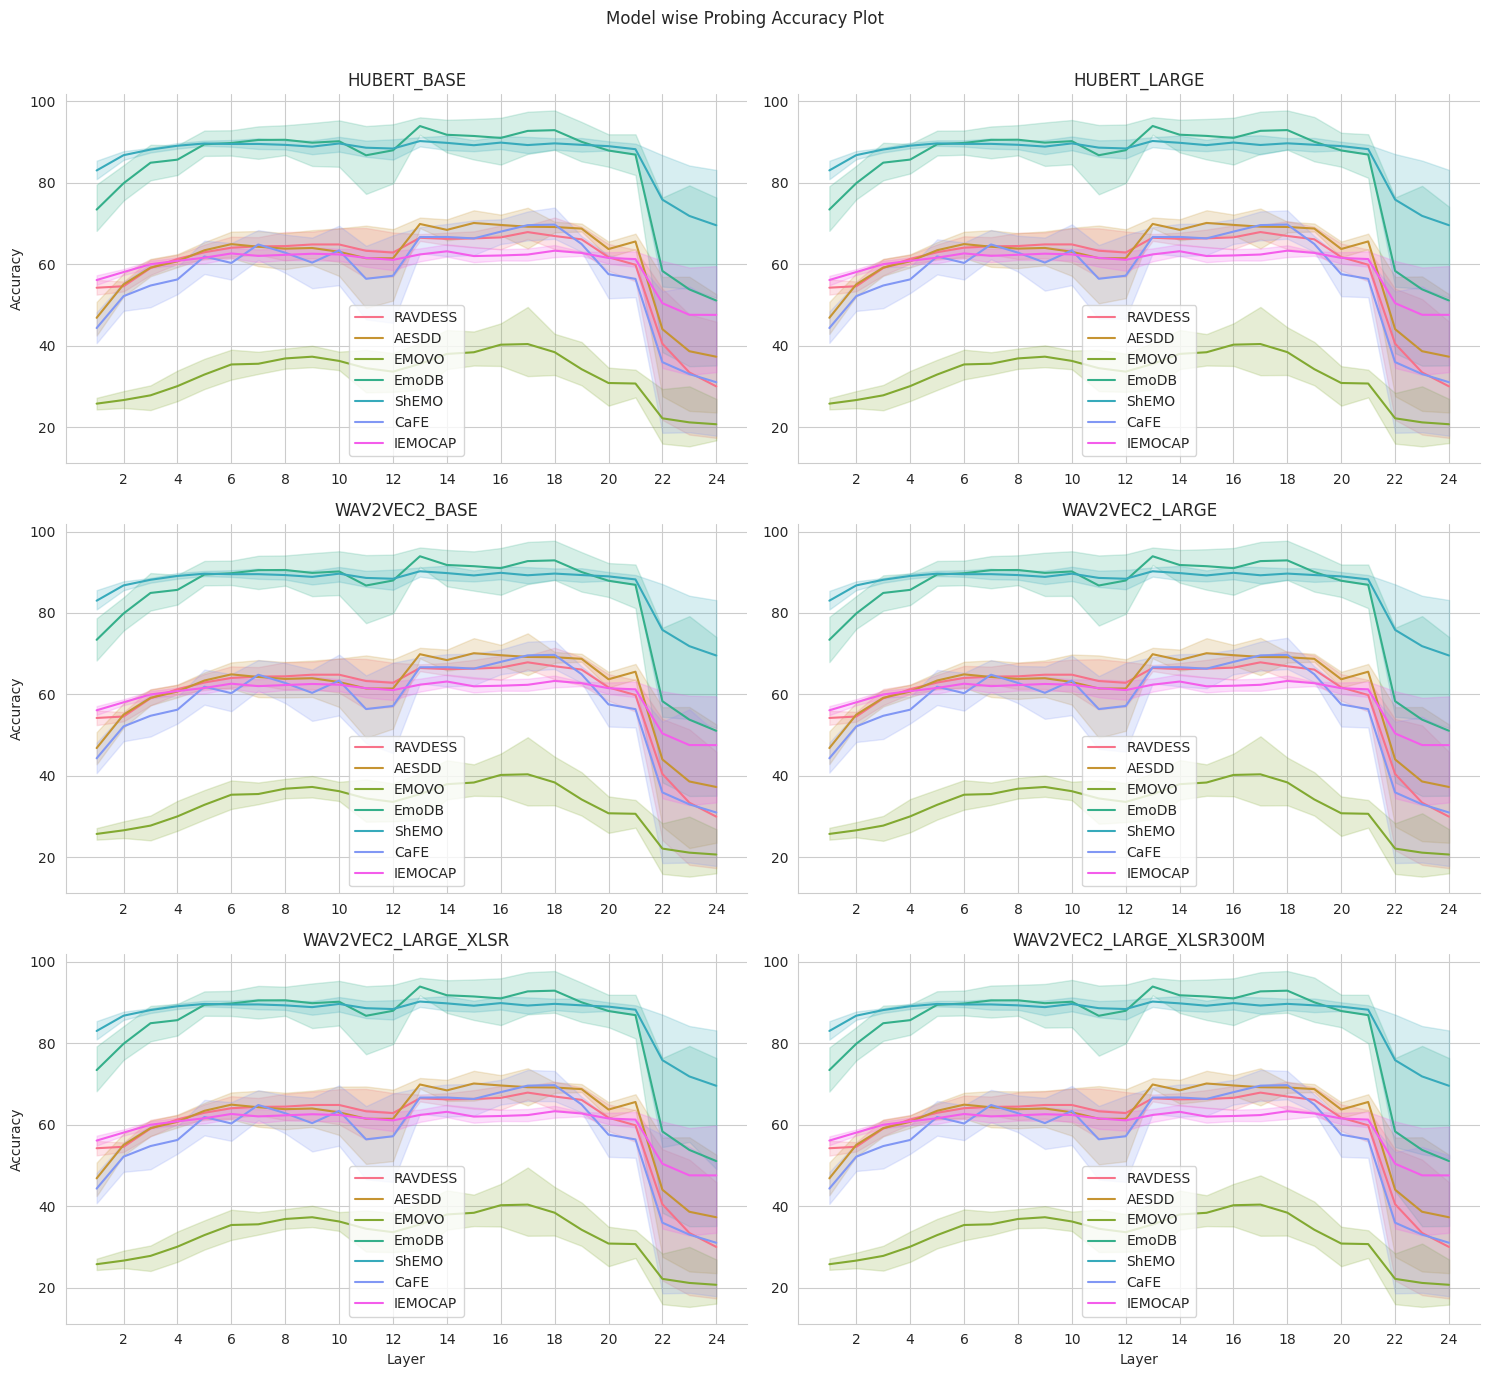

In [10]:
# Set figure
fig, ax = plt.subplots(3, 2,figsize=(15,14))
sns.set_style('whitegrid')

axes = np.array(ax).flatten()
models = sorted(probing_summary.model.unique())
for idx in range(len(models)):
    ax = axes[idx]
    model= models[idx]
    mean_accs, layers, datasets = [], [], []
    df = probing_summary[probing_summary.dataset==dataset]
    for row in range(probing_summary.shape[0]):
        mean_accs.extend(probing_summary.iloc[row].mean_accuracy)
        datasets.extend(([probing_summary.iloc[row].dataset]*len(probing_summary.iloc[row].mean_accuracy)))
        layers.extend([*range(1,len(probing_summary.iloc[row].mean_accuracy)+1)])
    df = pd.DataFrame.from_dict(dict(dataset=datasets,layer=layers,mean_accuracy=mean_accs))

    # Plot the lines
    sns.lineplot(df ,x='layer',y='mean_accuracy', hue='dataset',dashes=False,palette=sns.color_palette("husl",len(df.dataset.unique())),ax=ax)   
    # Adjust border
    sns.despine(top=True,right=True)

    # Set Labels, legends and ticks
    ax.set_title(model)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend(facecolor="w")#,loc=4,title='IDR')
    ax.set_xticks([*range(2,25,2)],labels=[*range(2,25,2)])
    # ax.set_xlim(1,30.6)

# Plot
axes[-1].set_xlabel("Layer")
axes[-2].set_xlabel("Layer")
axes[0].set_ylabel("Accuracy")
axes[2].set_ylabel("Accuracy")
axes[4].set_ylabel("Accuracy")
plt.suptitle('Model wise Probing Accuracy Plot\n\n')
plt.tight_layout()

plt.savefig(os.path.join(output_dir,'model_wise_probing_accuracy_plot.png'),bbox_inches="tight");
# plt.savefig(os.path.join(output_dir,'model_wise_probing_accuracy_plot.svg'),bbox_inches="tight");


# plt.clf();
# plt.close('all');